Import all libraries


In [1]:
import os
import zipfile
import requests
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import wn
from wn.similarity import wup
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from deep_translator import GoogleTranslator
import gensim
import kagglehub
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tarfile
import pickle
import torch
from transformers import MarianMTModel, MarianTokenizer

In [2]:
# Login to Kaggle
try:
    kagglehub.whoami()
except:
    kagglehub.login()

In [3]:
# Clone WNAffect repository
repo_url = "https://github.com/clemtoy/WNAffect.git"
clone_dir = "WNAffect"
if not os.path.exists(clone_dir):
    os.system(f"git clone {repo_url} {clone_dir}")
else:
    print("Failed to clone repository. Directory already exists.")

# Import WNAffect library and emotion class
from WNAffect.wnaffect import WNAffect
from WNAffect.emotion import Emotion

# Download the nltk data
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("omw-1.4")

# Download finnh wordnet
!python -m wn download omw-fi

# /& Download finnish word2vec model from kaggle
word2vec_fi = kagglehub.dataset_download("lehtol/word2vec-fi")

Failed to clone repository. Directory already exists.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!

Cached file found: C:\Users\janne\.wn_data\downloads\e22bb9bb7ec2fbb9254ce638a385cf3b2c5c4a58

Checking C:\Users\janne\AppData\Local\Temp\tmptlmcb9gx\omw-fi\omw-fi.xml
Skipping omw-fi:1.4 (FinnWordNet); already added



Implement function to download files from the internet and unpack them


In [4]:
# Download and extract zip file
def download_and_extract(url, zip_path, extract_path):
    if os.path.exists(extract_path):
        print(f"File {extract_path} already exists.")
    else:
        print(f"Downloading and extracting the {zip_path} to {extract_path}.")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))
        block_size = 1024
        with open(zip_path, "wb") as file, tqdm(
            desc=zip_path,
            total=total_size,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(block_size):
                file.write(data)
                bar.update(len(data))
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for member in zip_ref.namelist():
                member_path = os.path.join(
                    extract_path,
                    os.path.relpath(
                        member, start=os.path.commonpath(zip_ref.namelist())
                    ),
                )
                if member.endswith("/"):
                    os.makedirs(member_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(member_path), exist_ok=True)
                    with open(member_path, "wb") as f:
                        f.write(zip_ref.read(member))
        os.remove(zip_path)
        print(f"Download and extraction of {extract_path} complete.")


# Download single file
def download(url, file_path):
    if os.path.exists(file_path):
        print(f"File {file_path} already exists.")
    else:
        print(f"Downloading the file {file_path}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))
        block_size = 1024

        with open(file_path, "wb") as file, tqdm(
            desc=file_path,
            total=total_size,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(block_size):
                file.write(data)
                bar.update(len(data))
        print(f"Download of {file_path} complete.")


# Extract wordnet 1.6 tar file
def extract_wordnet16_tar(tar_path, extract_path):
    def is_within_directory(directory, target):
        abs_directory = os.path.abspath(directory)
        abs_target = os.path.abspath(target)
        return os.path.commonpath([abs_directory]) == os.path.commonpath(
            [abs_directory, abs_target]
        )

    def safe_extract(tar, path=".", members=None, *, numeric_owner=False):
        for member in tar.getmembers():
            member_path = os.path.join(path, member.name)
            if not is_within_directory(path, member_path):
                raise Exception("Attempted Path Traversal in Tar File")
        for member in members:
            if member.issym() or member.islnk():
                continue  # Skip symbolic links
            tar.extract(member, path, numeric_owner=numeric_owner, filter=None)

    with tarfile.open(tar_path, "r") as tar:
        members = [m for m in tar.getmembers() if m.name.startswith("wordnet-1.6/")]
        for member in members:
            member.name = member.name[len("wordnet-1.6/") :]
        safe_extract(tar, extract_path, members=members)


# Download and extract tar.gz file
def download_and_extract_targz(url, gz, path):
    if os.path.exists(path):
        print(f"File {path} already exists.")
    else:
        print(f"Downloading and extracting the {gz} to {path}.")
        download(url, gz)
        extract_wordnet16_tar(gz, path)
        os.remove(gz)

Download the Finnish Wikipedia 2017 dataset, Finnish Stopwords, Stemmer, FinnWordNet and Word2Vec.


In [5]:
# Wikipedia dataset
wiki_url = "https://www.kielipankki.fi/download/wikipedia-fi/wikipedia-fi-2017-src/wikipedia-fi-2017-src.zip"
wiki_zip_path = "wikipedia-fi-2017-src.zip"
wiki_extract_path = "data/wikipedia-fi-2017-src"
download_and_extract(wiki_url, wiki_zip_path, wiki_extract_path)

# Finnish Stopwords
stopword_url = "http://members.unine.ch/jacques.savoy/clef/finnishST.txt"
stopwords_path = "data/finnishST.txt"
download(stopword_url, stopwords_path)

# FinnWordNet
finnwordnet_url = (
    "https://www.kielipankki.fi/download/FinnWordNet/v2.0/FinnWordNet-2.0.zip"
)
finnwordnet_zip_path = "FinnWordNet-2.0.zip"
finnwordnet_extract_path = "data/FinnWordNet"
download_and_extract(finnwordnet_url, finnwordnet_zip_path, finnwordnet_extract_path)

# Wordnet 1.6
wordnet16_url = "https://wordnetcode.princeton.edu/1.6/wn16.unix.tar.gz"
wordnet16_gz = "wn16.unix.tar.gz"
wordnet16_path = "data/wn16"
download_and_extract_targz(wordnet16_url, wordnet16_gz, wordnet16_path)

# Download Wordnet Affect
wordnet_affect_url = "https://unioulu-my.sharepoint.com/:u:/g/personal/jyrjanai20_student_oulu_fi/EcfjOMVVQ7dIr_lETcSOFo4B5KEtVvB1I5mmWEVxjspDNQ?e=hKkcAj&download=1"
wordnet_affect_zip = "wndomains32.zip"
wordnet_affect_path = "data/wndomains32"
download_and_extract(wordnet_affect_url, wordnet_affect_zip, wordnet_affect_path)

File data/wikipedia-fi-2017-src already exists.
File data/finnishST.txt already exists.
File data/FinnWordNet already exists.
File data/wn16 already exists.
File data/wndomains32 already exists.


### Task 1:

Consider the wordings: “climate change”, “emission”, “resilience”, “sustainability” (need to consider their Finnish translations). Suggest a script where your input each of these wordings and output the corresponding Wikipedia pages, highlighting all the (linked) entities in these pages.


In [6]:
terms = ["ilmastonmuutos", "päästö", "joustavuus", "ekologinen kestävyys"]

In [7]:
# Function to load the extracted Wikipedia dataset
def load_wikipedia_dataset(directory):
    data = {}
    data_titles = {}

    # Iterate over all dataset parts
    files = [
        f
        for f in os.listdir(directory)
        if f.startswith("wiki_part") and f.endswith(".VRT")
    ]
    for filename in tqdm(files, desc="Processing files"):
        if filename.startswith("wiki_part") and filename.endswith(".VRT"):
            file_path = os.path.join(directory, filename)
            # print(f"Processing file: {file_path}")

            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()

                # Use regex to find all documents within the <doc>...</doc> tags
                docs = re.findall(
                    r'<doc id="(.*?)" url="(.*?)" title="(.*?)">(.*?)</doc>',
                    content,
                    re.DOTALL,
                )

                # Process each document found
                for doc_id, url, title, doc_content in docs:
                    data_titles[title.casefold()] = {
                        "id": doc_id,
                    }
                    # Only store the data if the title matches one of the specified terms
                    if title.casefold() in terms:
                        data[title.casefold()] = {
                            "id": doc_id,
                            "url": url,
                            "content": doc_content,
                        }
    return data, data_titles


# Load Finnish stopwords
def load_stopwords(file_path):
    with open(file_path, "r", encoding="ISO-8859-1") as f:
        stopwords = f.read().splitlines()
        print(f"Loaded {len(stopwords)} stopwords from {file_path}")
    return stopwords


# Function to highlight linked entities
def highlight_linked_entities(content):
    highlighted_content = re.sub(
        r'(<link entity=")(.*?)(">)(.*?)(</link>)', r"\1\2\3**\4**\5", content
    )
    return highlighted_content


# Function to tokenize text into sentences and remove stopwords
def remove_stopwords(sentence, stopwords, language="finnish"):
    words = word_tokenize(text=sentence, language=language)
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return " ".join(filtered_words)

Load the wikipedia dataset


In [8]:
dataset_directory = "data/wikipedia-fi-2017-src"  # Path to the extracted dataset
wikipedia_data, wikipedia_title_data = load_wikipedia_dataset(dataset_directory)
print(f"number of wikipedia titles", len(wikipedia_title_data))

Processing files: 100%|██████████| 66/66 [00:48<00:00,  1.35it/s]

number of wikipedia titles 425318


Load the finnish stopwords


In [9]:
finnish_stopwords = load_stopwords(stopwords_path)

Loaded 747 stopwords from data/finnishST.txt


Highlight the entities in the wikipedia pages


In [10]:
for title, info in wikipedia_data.items():
    highlighted_content = highlight_linked_entities(info["content"])
    # print(f"Title: {title}\nHighlighted Content: {highlighted_content}\n")

Get the pages for the given wordings and get the sentences


In [11]:
# Function to extract third column data from sentences, which has the word in base form
def extract_third_column(sentence):
    third_column_data = []
    lines = sentence.strip().split("\n")
    for line in lines:
        if line.strip() and not line.startswith("<"):
            columns = line.split("\t")
            if len(columns) > 2:
                third_column_data.append(columns[2])
    return third_column_data


# Function to process paragraphs and extract third column data
def process_paragraphs(input_text):
    # print(f"Input Text: {input_text}")
    paragraphs = re.findall(r"<paragraph>(.*?)</paragraph>", input_text, re.DOTALL)
    all_third_column_data = []
    # print(f"Paragraphs: {paragraphs}")
    for paragraph in paragraphs:
        sentences = re.findall(r"<sentence>(.*?)</sentence>", paragraph, re.DOTALL)
        # print(f"Sentences: {sentences}")
        for sentence in sentences:
            # print(f"Sentence: {sentence}")
            third_column_data = extract_third_column(sentence)
            all_third_column_data.append(" ".join(third_column_data))
    return all_third_column_data


# Process each item in wikipedia_data
for item in wikipedia_data.items():
    third_column_data = process_paragraphs(item[1]["content"])
    for j, data in enumerate(third_column_data):
        filtered_sentence = remove_stopwords(data, finnish_stopwords)

all_words = {}
all_words_base = {}

print(wikipedia_data)
for title, document in wikipedia_data.items():
    sentences = re.findall(
        r"<sentence>(.*?)</sentence>", document["content"], re.DOTALL
    )
    document_words = []
    document_words_base = []
    if sentences:
        for idx, sentence_content in enumerate(sentences):
            # print(f"Processing sentence {idx + 1}...")
            # Split each sentence into individual lines
            lines = sentence_content.strip().split("\n")
            # cleaned_lines = re.sub(r'[^\w\s]', '', lines)
            # Extract the word (3nd column) from each line
            words = [line.split("\t")[1] for line in lines if line.strip()]
            words_base = [line.split("\t")[2] for line in lines if line.strip()]

            for word in words:
                cleaned_word = re.sub(r"[^\w\s]", "", word)
                if not cleaned_word or cleaned_word in finnish_stopwords:
                    continue
                document_words.append(cleaned_word.casefold())

            for word_base in words_base:
                cleaned_word_base = re.sub(r"[^\w\s]", "", word_base)
                if not cleaned_word_base or cleaned_word_base in finnish_stopwords:
                    continue
                document_words_base.append(cleaned_word_base.casefold())

    all_words[title] = document_words
    all_words_base[title] = document_words_base

for title, words in all_words.items():
    print(f"\nWords for document '{title}': {words}")

for title, words in all_words_base.items():
    print(f"\nWords for document base '{title}': {words}")

{'joustavuus': {'id': '62900', 'url': 'https://fi.wikipedia.org/wiki?curid=62900', 'content': '\n<paragraph>\n<sentence>\n1\tJoustavuus\tjoustavuus\tNOUN\t_\tCase=Nom|Number=Sing\t0\troot\t_\t_\n</sentence>\n</paragraph>\n<paragraph>\n<sentence>\n1\tJoustavuus\tjoustavuus\tNOUN\t_\tCase=Nom|Number=Sing\t4\tnsubj:cop\t_\t_\n2\ton\tolla\tVERB\t_\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n3\tyrityksen\tyritys\tNOUN\t_\tCase=Gen|Number=Sing\t4\tnmod:poss\t_\t_\n4\tominaisuus\tominaisuus\tNOUN\t_\tCase=Nom|Number=Sing\t0\troot\t_\t_\n5\t,\t,\tPUNCT\t_\t_\t7\tpunct\t_\t_\n6\tjoka\tjoka\tPRON\t_\tCase=Nom|Number=Sing|PronType=Rel\t7\tnsubj\t_\t_\n7\tkertoo\tkertoa\tVERB\t_\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tacl:relcl\t_\t_\n8\tsiitä\tse\tPRON\t_\tCase=Ela|Number=Sing|PronType=Dem\t7\tnmod\t_\t_\n9\t,\t,\tPUNCT\t_\t_\t12\tpunct\t_\t_\n10\tmiten\tmiten\tADV\t_\t_\t12\tadvmod\t_\t_\n11\tyritys\tyritys\tNOUN\t_\tCase=Nom|Numbe

In [12]:
# Find entities in the Wikipedia dataset

entities_found = {}
for i, topic_words in enumerate(all_words_base):
    print(f"Processing document '{topic_words}'...")
    found_words = []
    print(f"Processing document '{all_words_base[topic_words]}'")
    for word in all_words_base[topic_words]:
        if word.casefold() in [title.casefold() for title in wikipedia_title_data]:
            found_words.append(word.casefold())
    entities_found[topic_words] = found_words


# Example usage of the entities_found dictionary
for topic, found_entities in entities_found.items():
    print(f"Document '{topic}' contains the following entities: {found_entities}")

Processing document 'joustavuus'...
Processing document '['joustavuus', 'joustavuus', 'yritys', 'ominaisuus', 'kertoa', 'yritys', 'pystyä', 'sopeutua', 'kysyntä', 'tapahtua', 'määrällinen', 'laadullinen', 'muutos', 'yritys', 'muutos', 'kilpailija', 'epäedullinen', 'asema', 'anna', 'pollert', 'arvostella', 'käsite', 'joustavuus', 'varjo', 'tehdä', 'poiketa', 'työntekijä', 'asema', 'vaikuttaa', 'toimenpide', 'joustavuus', 'pyrkiä', 'oikeuttaa', 'keskenään', 'ristiriitainen', 'toimenpide', 'täsmällinen', 'kielenkäyttö', 'joustavuus', 'jakaa', 'laji', 'joustavuus', 'lyhytaikainen', 'ennakointi', 'flexibility', 'for', 'shortterm', 'predicatability', 'määrällinen', 'jousto', 'joustavuus', 'pitkäaikainen', 'sopeutua', 'flexibility', 'for', 'longterm', 'adaptability', 'toiminnallinen', 'jousto', 'joustavuus', 'lyhytaikainen', 'ennakointi', 'merkitä', 'yritys', 'voida', 'sopeuttaa', 'tuotantokustannus', 'kysyntä', 'tekninen', 'ominaisuus', 'lyhytaikainen', 'joustavuus', 'lisätä', 'mahdollisuus'

### Task 2

Assume the content of each webpage is a single document. Use relevant NLTK script to create a corpus constituted of the four document, and appropriate proprocessing and lemmatization, to construct the TfIdfVectorizer of each document and then calculate the cosine similarity of each pair of these documents. Provide the result in a table and comment on the findings.


In [13]:
# Preprocessing function to remove stopwords, stem, and tokenize the document
def preProcess(words, stopwords):
    tokens = []
    clean_stopwords = [word.casefold() for word in stopwords]
    stemmer = SnowballStemmer("finnish")

    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if word.isalpha() and word not in clean_stopwords]
    words_set = list(set(words))

    tokens.extend(words_set)

    return " ".join(tokens)

In [14]:
# Preprocess the document
corpus = []

for title, words in all_words.items():
    processed_doc = preProcess(words, finnish_stopwords)
    print(f"Processed Document: {processed_doc}")
    corpus.append(processed_doc)

# Print the processed document
print("\nCorpus:")
for doc in corpus:
    print(doc)

Processed Document: työntekijö motivoiv toimeentulo joustavuusidea johtaj uudenl saattav liittyv vuokratyövoim alihankin säännöllis toimial henkilöstöhallino työttömyyskorvauks sopeutumis an hakeutui longterm täsmällis ulkoistamin työntekij kilpailij hank pitkäaikaistyöttöm tapahtuv voima olev pollert arvostelu joustavuud kehit for alentue vaara urakehityks ajav työttöm entis kannustavuut joustavuus yle esimerk suunnittelij käsit työttömyysvakuutuks heidä perustu pystyy ristiriitais heikentäm atkinso pohj pienem ayliik kannustav korvauks riittäv markkinatilant jne ominaisuuks idea yd samanaikais tuotantokustannuks työttömyyskorvau yritys predicatability vastust laj lyhytaik mon irtisano suuremp toteut lyhentäm poikkeav ajam varj toimenpit aut yrity tarv use henkilöstöhallin havainto pysyv fordistis töitä työnkuv adaptability mekanism tois työsuht jousto tuotantoprosesia aletu ominaisuus tehd käytettäv ilmiö laadullis asem edustaj mahdollisuud lyhytaikais korvaus eril muutu piir pitkäai

In [15]:
# TF-IDF Vectorization of each document
tf = TfidfVectorizer(use_idf=True, min_df=1)
tfidf_matrix = tf.fit_transform(corpus)

In [16]:
# Compute cosine similarity of each pair of these documents
cosine_sim = cosine_similarity(tfidf_matrix)

In [17]:
# Provide the result in a table
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=[f"Doc{i+1}" for i in range(len(cosine_sim))],
    columns=[f"Doc{i+1}" for i in range(len(cosine_sim))],
)

print(cosine_sim_df)

          Doc1      Doc2      Doc3      Doc4
Doc1  1.000000  0.057823  0.005550  0.000000
Doc2  0.057823  1.000000  0.066185  0.025227
Doc3  0.005550  0.066185  1.000000  0.016994
Doc4  0.000000  0.025227  0.016994  1.000000


#### comments on the findings

The cosine similarity matrix shows the similarity between the documents as pairs. Most of the scores are closer to 0,
indicating that some documents share small amounts of content, but overall, the documents are mostly dissimilar based on these scores.


### Task 3

Repeat 2) when the documents are restricted only to clickable entities of each document


In [18]:
# Preprocessing function to remove stopwords, stemming
def preProcess_entites(words, stopwords):
    clean_stopwords = [word.casefold() for word in stopwords]
    stemmer = SnowballStemmer("finnish")

    words = [stemmer.stem(word) for word in words]

    words = [word for word in words if word.isalpha() and word not in clean_stopwords]

    words = list(set(words))

    return " ".join(words)

In [19]:
# Preprocess the document
corpus_entity = []
for document, found_entities in entities_found.items():
    processed_doc = preProcess_entites(found_entities, finnish_stopwords)
    corpus_entity.append(processed_doc)

# Print the processed document
print("\nCorpus_entity:")
for doc in corpus_entity:
    print(doc)


Corpus_entity:
tarv havainto työ johtaj piiri atkinso tuote pohj ennakoint muutos työttömyysvakuutus vuokratyövoim toimial jousto määrä an yd ominaisuus työntekij suomi ilmiö projekt ns laji voima asem yritys strateg mal mahdollisuus vaara joustavuus ide käsit varj
ihmin tila säteilypakot energ öljy yleiskiel kaasu merenpohj päivä tutk muoto ilmasto muutos syy toimin merk tieto suomi eteenp proses milj suun puu kasvihuonekaasu meriv pelto kalkkikiv hiki ilmastomal aktiivisuus maailmanhistor käsit maaper lämpökapasiteet tekniik kivihiil pohj ppm ympäristö v raport biodiversiteet poltoa osa pudo aur teollisuusm tutkimus aerosol päästö lämpötil nykyaik tekij siper ilm voimakkuus rata vuori alask säteily maakaasu merivir kiertor vuosis havainto celsiusast merkitys dynamiik siitepöly hiili vuorovaikutus histor aurinkokun tulivuorenpurkaus kosteiko suure maatalous tapahtum todistusaineisto lap jääkairausnäyt no sadan meta nitraat hiilidioksid tarkoitus toimi aksel pala palo kivihiilikau c k

In [20]:
# TF-IDF Vectorization of each document
tf = TfidfVectorizer(use_idf=True, min_df=1)
tfidf_matrix_entity = tf.fit_transform(corpus_entity)

In [21]:
# Compute cosine similarity of each pair of these documents
cosine_sim_entity = cosine_similarity(tfidf_matrix_entity)

In [22]:
# Provide the result in a table
cosine_sim_df_entity = pd.DataFrame(
    cosine_sim_entity,
    index=[f"Doc{i+1}" for i in range(len(cosine_sim_entity))],
    columns=[f"Doc{i+1}" for i in range(len(cosine_sim_entity))],
)

print(cosine_sim_df_entity)

          Doc1      Doc2      Doc3      Doc4
Doc1  1.000000  0.066520  0.022306  0.000000
Doc2  0.066520  1.000000  0.152217  0.045353
Doc3  0.022306  0.152217  1.000000  0.000000
Doc4  0.000000  0.045353  0.000000  1.000000


#### Comments on the findings

The results are similar to task 2, with most of the scores being closer to 0. However, in the case of clickable entities, there is a higher similarity between Doc2 and Doc3 compared to task 2.


### Task 4

Write a script that explores the clickable entities in each of the four concepts (exploring only once), and generates new extended vocabulary for each concepts, and compute the new similarity between each pair of concepts using extent of overlapping of overall vocabulary and reduced vocabulary (when restricting the vocabulary to clickable entities). We shall refer to the case where the clickable entities are further explored as extended vocabulary case.


In [23]:
# Function to further explore clickable entities and generate extended vocabulary
# Function to load the extracted Wikipedia dataset
def load_wikipedia_dataset_extended(directory):
    data_entity_voc = {}
    nodup = {}
    categories = ["ilmastonmuutos", "päästö", "joustavuus", "ekologinen kestävyys"]
    data_entity_voc = {category: [] for category in categories}
    for topic, found_entities in entities_found.items():
        nodup[topic] = list(set(found_entities))

    # Iterate over all dataset parts
    files = [
        f
        for f in os.listdir(directory)
        if f.startswith("wiki_part") and f.endswith(".VRT")
    ]

    for filename in tqdm(files, desc="Processing files"):
        if filename.startswith("wiki_part") and filename.endswith(".VRT"):
            file_path = os.path.join(directory, filename)
            # print(f"Processing file: {file_path}")

            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()

                # Use regex to find all documents within the <doc>...</doc> tags
                docs = re.findall(
                    r'<doc id="(.*?)" url="(.*?)" title="(.*?)">(.*?)</doc>',
                    content,
                    re.DOTALL,
                )

                # Process each document found
                for doc_id, url, title, doc_content in docs:
                    # Loop through the relevant categories in 'nodup' to reduce repetitive code
                    for category in categories:
                        # Check if the title matches the category terms in 'nodup'
                        if title.casefold() in nodup[category]:
                            # Create a dictionary with the document data
                            document_data = {
                                "title": title,
                                "id": doc_id,
                                "url": url,
                                "content": doc_content,
                            }

                            # Append the document data to the corresponding category in 'data_entity_voc'
                            data_entity_voc[category].append(document_data)

    return data_entity_voc

In [24]:
#
dataset_directory = "data/wikipedia-fi-2017-src"  # Path to the extracted dataset
documents_extended = load_wikipedia_dataset_extended(dataset_directory)

Processing files: 100%|██████████| 66/66 [00:49<00:00,  1.32it/s]


In [25]:
def list_extended_words(documents_extended):
    all_words_extended = {}

    for title, documents in documents_extended.items():
        for doc in documents:
            sentences = re.findall(
                r"<sentence>(.*?)</sentence>", doc["content"], re.DOTALL
            )
            document_words = []
            if sentences:
                for idx, sentence_content in enumerate(sentences):
                    # print(f"Processing sentence {idx + 1}...")

                    # Split each sentence into individual lines
                    lines = sentence_content.strip().split("\n")

                    # cleaned_lines = re.sub(r'[^\w\s]', '', lines)
                    # Extract the word (3nd column) from each line
                    words = [line.split("\t")[1] for line in lines if line.strip()]
                    for word in words:
                        cleaned_word = re.sub(r"[^\w\s]", "", word)
                        if not cleaned_word or cleaned_word in finnish_stopwords:
                            continue
                        document_words.append(cleaned_word.casefold())

            if title in all_words_extended:
                all_words_extended[title].extend(document_words)
            else:
                # If the title doesn't exist, initialize it with the document_words list
                all_words_extended[title] = document_words

    return all_words_extended

In [26]:
words_extended = list_extended_words(documents_extended)

words_extended_all = (
    {}
)  # extended words for all documents "ilmastonmuutos", "päästö", "joustavuus", "ekologinen kestävyys"

categories = ["ilmastonmuutos", "päästö", "joustavuus", "ekologinen kestävyys"]
words_extended_all = {category: [] for category in categories}

for title, words in all_words.items():
    words_extended_all[title] = all_words[title] + words_extended[title]

In [27]:
# Preprocessing function to remove stopwords, stemming
def preProcess_extended_words(words, stopwords):
    clean_stopwords = [word.casefold() for word in stopwords]
    stemmer = SnowballStemmer("finnish")

    words = [stemmer.stem(word) for word in words]

    words = [word for word in words if word.isalpha() and word not in clean_stopwords]

    words = list(set(words))

    return " ".join(words)


# Compute similiarity for the extended words


def compute_similarity(vocab1, vocab2):
    # Join vocabularies into a single string for each concept
    text1 = " ".join(vocab1)
    text2 = " ".join(vocab2)

    # Use TfidfVectorizer to create a matrix of the text
    tf = TfidfVectorizer(use_idf=True, min_df=1)
    tfidf_matrix = tf.fit_transform([text1, text2])

    # Compute cosine similarit
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    return cosine_sim

In [28]:
# Preprocess the extended words + original words and extended words

words_extended_preproces = {}
words_extended_all_preproces = {}

categories = ["ilmastonmuutos", "päästö", "joustavuus", "ekologinen kestävyys"]
words_extended_preproces = {category: [] for category in categories}
words_extended_all_preproces = {category: [] for category in categories}
words_all_preproces = {category: [] for category in categories}

for document, words in words_extended.items():
    processed_doc_ext = preProcess_entites(words, finnish_stopwords)
    words_extended_preproces[document].append(processed_doc_ext)

for document, words in words_extended_all.items():
    processed_doc_ext_all = preProcess_entites(words, finnish_stopwords)
    words_extended_all_preproces[document].append(processed_doc_ext_all)


for document, words in all_words.items():
    processed_doc_ext_all = preProcess_entites(words, finnish_stopwords)
    words_all_preproces[document].append(processed_doc_ext_all)

In [29]:
# Compute similarity for the extended words + original words and extended words

similarities_org = {}
for title in categories:
    similarities_org[title] = compute_similarity(
        words_all_preproces[title], words_extended_preproces[title]
    )

similarities_ext = {}
for title in categories:
    similarities_ext[title] = compute_similarity(
        words_extended_preproces[title], words_extended_all_preproces[title]
    )

print("Similarity between the original and extended vocabulary:")
for title, similarity in similarities_org.items():
    print(
        f"Similarity between the original of '{title}' and extended vocabulary: {similarity}"
    )

print()
print("Similarity between the extended and extended + original vocabulary:")
for title, similarity in similarities_ext.items():
    print(
        f"Similarity between the extended of '{title}' and extended + original vocabulary: {similarity}"
    )

Similarity between the original and extended vocabulary:
Similarity between the original of 'ilmastonmuutos' and extended vocabulary: 0.12776082828139848
Similarity between the original of 'päästö' and extended vocabulary: 0.09482468983038699
Similarity between the original of 'joustavuus' and extended vocabulary: 0.12184491476533445
Similarity between the original of 'ekologinen kestävyys' and extended vocabulary: 0.039369287475054957

Similarity between the extended and extended + original vocabulary:
Similarity between the extended of 'ilmastonmuutos' and extended + original vocabulary: 0.9999999999999123
Similarity between the extended of 'päästö' and extended + original vocabulary: 0.9999999999999851
Similarity between the extended of 'joustavuus' and extended + original vocabulary: 0.9999999999999964
Similarity between the extended of 'ekologinen kestävyys' and extended + original vocabulary: 0.9962371839883619


### Task 5

We want to assess the importance of each of the four concepts by the number of clickable entities including in the webpage of the given concept. Write a script that implements this strategy to determine the importance of each concept. Next, we want to use the extended vocabulary by quantifying the importance of individual entity in the original webpage by the number of clickable links it generates. Summarize a table highlighting the order of importance of the four concepts according to each of the original and extended vocabulary.


In [30]:
# calculate the occurance of each entity in the entities_found
entity_occurence = {}
for topic, found_entities in entities_found.items():
    entity_occurence[topic] = {}
    for entity in found_entities:
        if entity in entity_occurence[topic]:
            entity_occurence[topic][entity] += 1
        else:
            entity_occurence[topic][entity] = 1

# order the entities by occurance
sorted_entities = {}
for topic, entities in entity_occurence.items():
    sorted_entities[topic] = {
        k: v
        for k, v in sorted(entities.items(), key=lambda item: item[1], reverse=True)
    }

## print the sorted entities for each topic
for topic, entities in sorted_entities.items():
    print(f"Document '{topic}' contains entities:")
    print(entities)

Document 'joustavuus' contains entities:
{'joustavuus': 14, 'yritys': 11, 'asema': 5, 'työntekijä': 5, 'jousto': 3, 'ominaisuus': 2, 'muutos': 2, 'ennakointi': 2, 'mahdollisuus': 2, 'malli': 2, 'työ': 2, 'anna': 1, 'käsite': 1, 'varjo': 1, 'laji': 1, 'tuote': 1, 'toimiala': 1, 'tarve': 1, 'voima': 1, 'strategia': 1, 'ilmiö': 1, 'havainto': 1, 'pohja': 1, 'atkinson': 1, 'ydin': 1, 'johtaja': 1, 'projekti': 1, 'vaara': 1, 'vuokratyövoima': 1, 'työttömyysvakuutus': 1, 'piiri': 1, 'määrä': 1, 'idea': 1, '2015': 1, 'suomi': 1, 'ns': 1}
Document 'ilmastonmuutos' contains entities:
{'ilmasto': 26, 'ilmakehä': 19, 'muutos': 12, 'miljoona': 10, 'ihminen': 7, 'hiilidioksidi': 7, 'toiminta': 6, 'prosessi': 5, 'päästö': 5, 'polttoaine': 5, 'kasvihuonekaasu': 5, 'maa': 4, 'osa': 4, 'ilmastomalli': 4, 'takaisinkytkentä': 4, 'artikkeli': 3, 'tekijä': 3, 'liike': 3, 'aurinko': 3, 'aktiivisuus': 3, 'määrä': 3, 'jäätikkö': 3, 'muoto': 3, 'metaani': 3, 'suo': 3, 'sadanta': 2, 'lämpötila': 2, 'meri': 2, '

In [31]:
## words_extended_all contains the extended vocabulary for each document
## entities_found contains the entities found in each document


def count_clickable_links(entities):
    return {entity: len(entity) for entity in entities}


# Count clickable links for original and extended vocabulary
original_counts = {
    concept: count_clickable_links(entities)
    for concept, entities in entities_found.items()
}
extended_counts = {
    concept: count_clickable_links(entities)
    for concept, entities in words_extended_all.items()
}

# Summarize importance
original_importance = {
    concept: sum(counts.values()) for concept, counts in original_counts.items()
}
extended_importance = {
    concept: sum(counts.values()) for concept, counts in extended_counts.items()
}

# Create a DataFrame to summarize the importance
importance_df = pd.DataFrame(
    {
        "Concept": list(original_importance.keys()),
        "Original Importance": list(original_importance.values()),
        "Extended Importance": list(extended_importance.values()),
    }
)

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(
    by=["Original Importance", "Extended Importance"], ascending=False
)

# Display the table
print(importance_df)

                Concept  Original Importance  Extended Importance
1        ilmastonmuutos                 1016                30450
0            joustavuus                  241               260865
2                päästö                   91                87638
3  ekologinen kestävyys                   64                23725


### Task 6

We want to assess the similarity between the concepts is reflected in the their webpage content. Use a script to calculate Wu and Palmer WordNet semantic similarity between each pair of the four concepts and then compare result with the Jaccard similarity obtained by both original vocabulary in 2) and extended vocabulary 4), and comment on the compatibility between the semantic similarity and the above constructed Jaccard similarity measures


In [32]:
finnwordnet_path = "data/FinnWordNet/dict"
# wn = WordNetCorpusReader(finnwordnet_path, None)

fi = wn.Wordnet("omw-fi")

C:\Users\janne\AppData\Local\Temp\ipykernel_104224\2577086909.py:4: WnWarning: lexicon dependencies not available: omw-en:1.4
  fi = wn.Wordnet("omw-fi")


In [33]:
# Wu and Palmer WordNet Semantic Similarity Calculation
terms_list = list(terms)
wu_palmer_similarity = []
for i in range(len(terms_list)):
    row = []
    for j in range(len(terms_list)):
        if i == j:
            row.append(1.0)
        else:
            synsets_1 = fi.synsets(terms_list[i])
            synsets_2 = fi.synsets(terms_list[j])
            max_similarity = 0
            for syn1 in synsets_1:
                for syn2 in synsets_2:
                    similarity = wup(syn1, syn2, simulate_root=True)
                    if similarity and similarity > max_similarity:
                        max_similarity = similarity
            row.append(max_similarity if max_similarity else 0)
    wu_palmer_similarity.append(row)

# Provide the result in a table
wu_palmer_sim_df = pd.DataFrame(
    wu_palmer_similarity,
    index=[f"Concept{i+1}" for i in range(len(terms_list))],
    columns=[f"Concept{i+1}" for i in range(len(terms_list))],
)

print("\nWu and Palmer WordNet Semantic Similarity:")
print(wu_palmer_sim_df)


# Jaccard Similarity Calculation for Original and Extended Vocabulary
def jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set(set2)))
    union = len(set(set1).union(set(set2)))
    return intersection / union if union != 0 else 0


# Calculate Jaccard Similarity for Original and Extended Vocabularies
jaccard_original = []
jaccard_extended = []
for i in range(len(terms_list)):
    row_original = []
    row_extended = []
    for j in range(len(terms_list)):
        if i == j:
            row_original.append(1.0)
            row_extended.append(1.0)
        else:
            row_original.append(
                jaccard_similarity(all_words[terms_list[i]], all_words[terms_list[j]])
            )
            row_extended.append(
                jaccard_similarity(
                    words_extended_all[terms_list[i]], words_extended_all[terms_list[j]]
                )
            )
    jaccard_original.append(row_original)
    jaccard_extended.append(row_extended)

# Provide the results in tables
jaccard_original_df = pd.DataFrame(
    jaccard_original,
    index=[f"Concept{i+1}" for i in range(len(terms_list))],
    columns=[f"Concept{i+1}" for i in range(len(terms_list))],
)

jaccard_extended_df = pd.DataFrame(
    jaccard_extended,
    index=[f"Concept{i+1}" for i in range(len(terms_list))],
    columns=[f"Concept{i+1}" for i in range(len(terms_list))],
)

print(f"\nJaccard Similarity (Original Vocabulary):")
print(jaccard_original_df)
print(f"\nJaccard Similarity (Extended Vocabulary):")
print(jaccard_extended_df)

"""
Wu and Palmer WordNet Semantic Similarity:
Concept1 (Joustavuus) and Concept4 (Ekologinen kestävyys) have a moderate similarity of 0.5, indicating that they share some semantic proximity.
Concept3 (Päästö) has a low semantic similarity with other concepts (0.0), suggesting minimal semantic overlap based on WordNet relations.

Jaccard Similarity (Original Vocabulary):
The Jaccard similarity is low for most pairs, indicating very little lexical overlap in the original vocabulary.

Jaccard Similarity (Extended Vocabulary):
The Jaccard similarity increases for most pairs in the extended vocabulary, suggesting a higher lexical overlap due to the inclusion of additional entities.
"""


Wu and Palmer WordNet Semantic Similarity:
          Concept1  Concept2  Concept3  Concept4
Concept1       1.0       0.5       0.5       0.0
Concept2       0.5       1.0       0.5       0.0
Concept3       0.5       0.5       1.0       0.0
Concept4       0.0       0.0       0.0       1.0

Jaccard Similarity (Original Vocabulary):
          Concept1  Concept2  Concept3  Concept4
Concept1  1.000000  0.009036  0.014634  0.003101
Concept2  0.009036  1.000000  0.000000  0.000000
Concept3  0.014634  0.000000  1.000000  0.000000
Concept4  0.003101  0.000000  0.000000  1.000000

Jaccard Similarity (Extended Vocabulary):
          Concept1  Concept2  Concept3  Concept4
Concept1  1.000000  0.099610  0.241761  0.086969
Concept2  0.099610  1.000000  0.082558  0.078804
Concept3  0.241761  0.082558  1.000000  0.065701
Concept4  0.086969  0.078804  0.065701  1.000000


'\nWu and Palmer WordNet Semantic Similarity:\nConcept1 (Joustavuus) and Concept4 (Ekologinen kestävyys) have a moderate similarity of 0.5, indicating that they share some semantic proximity.\nConcept3 (Päästö) has a low semantic similarity with other concepts (0.0), suggesting minimal semantic overlap based on WordNet relations.\n\nJaccard Similarity (Original Vocabulary):\nThe Jaccard similarity is low for most pairs, indicating very little lexical overlap in the original vocabulary.\n\nJaccard Similarity (Extended Vocabulary):\nThe Jaccard similarity increases for most pairs in the extended vocabulary, suggesting a higher lexical overlap due to the inclusion of additional entities.\n'

#### comment on the compatibility between the semantic similarity and the above constructed Jaccard similarity measures


### Task 7

Now we want to evaluate the emotion of the text in each dataframe. For this purpose, use WordnetAffect (https://github.com/clemtoy/WNAffect), which generates an emotion state and the part of speech tag of each word matched in the lexicon, and then compile the overall output for each concept. Repeat this process for both restricted and extended vocabulary cases, and comment on the compatibility between the emotion gained from the corresponding Wikipedia page and the intuitive emotion from individual concept.


In [34]:
# Analysis Using WordNetAffect
wna = WNAffect(wordnet16_path, wordnet_affect_path)

Because there is no implementation of affective lexicon in Finnish, we will use the English version of the lexicon to evaluate the emotion of the text. The results may not be accurate, but we can still get an idea of the emotions in the text. We will be using MarianMT with Helsinki-NLP opus-mt-fi-en model to translate the text to English before evaluating the emotions, because it is done locally and free to use.


In [35]:
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "Helsinki-NLP/opus-mt-tc-big-fi-en"
small_model_name = "Helsinki-NLP/opus-mt-fi-en"
print(f"Device: {device}")


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


def translate_batch_marian(
    words, model_name="Helsinki-NLP/opus-mt-fi-en", batch_size=1
):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MarianMTModel.from_pretrained(model_name).to(device)
    tokenizer = MarianTokenizer.from_pretrained(model_name)

    translations = []
    total_words = len(words)
    with tqdm(total=total_words, desc="Translating batches") as pbar:
        for src_text_list in chunks(words, batch_size):
            batch = tokenizer(
                src_text_list, return_tensors="pt", padding=True, truncation=True
            ).to(device)
            gen = model.generate(**batch)
            translated_text = tokenizer.batch_decode(gen, skip_special_tokens=True)
            translations.extend(translated_text)
            pbar.update(len(src_text_list))
            # print(f"Translated {translations} words")

    return translations


def load_or_translate(all_words, filename="translated_all_words.pkl", batch_size=1):
    """Load translated words from disk if available, otherwise translate and save to disk."""
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            translated_all_words = pickle.load(f)
        print("Loaded translated words from disk.")
    else:
        translated_all_words = {}
        for term, vocab in all_words.items():
            translated_vocab = translate_batch_marian(
                vocab, small_model_name, batch_size=batch_size
            )
            translated_all_words[term] = translated_vocab

        with open(filename, "wb") as f:
            pickle.dump(translated_all_words, f)
        print("Translated words saved to disk.")
    return translated_all_words


def clean_word(word):
    """Remove non-alphanumeric characters from a word."""
    clean = re.sub(r"[^\w]", "", word, flags=re.UNICODE)
    cased = clean.casefold()
    return cased


def split_and_clean(content):
    """Split content into words and clean each word."""
    words = content.split()
    clean_array = [clean_word(word) for word in words]
    results = list(filter(None, clean_array))
    return results

CUDA: True
Device: cuda:0


Clean the texts from any special characters before translating them to English.


In [37]:
clean_all_before_translate = {}
for title, words in all_words.items():
    clean_all_before_translate[title] = []
    for content in words:
        clean_all_before_translate[title].extend(split_and_clean(content))

clean_extended_before_translate = {}
for title, words in words_extended.items():
    clean_extended_before_translate[title] = []
    for content in words:
        clean_extended_before_translate[title].extend(split_and_clean(content))

print("All words length before cleaning:")
for title, words in all_words.items():
    print(f"Document '{title}' contains {len(words)} words.")

print("Cleaned words length:")
for title, words in clean_all_before_translate.items():
    print(f"Document '{title}' contains {len(words)} words.")

print("Extended words length before cleaning:")
for title, words in words_extended.items():
    print(f"Document '{title}' contains {len(words)} words.")

print("Cleaned extended words length:")
for title, words in clean_extended_before_translate.items():
    print(f"Document '{title}' contains {len(words)} words.")

All words length before cleaning:
Document 'joustavuus' contains 233 words.
Document 'ilmastonmuutos' contains 803 words.
Document 'päästö' contains 43 words.
Document 'ekologinen kestävyys' contains 23 words.
Cleaned words length:
Document 'joustavuus' contains 233 words.
Document 'ilmastonmuutos' contains 803 words.
Document 'päästö' contains 43 words.
Document 'ekologinen kestävyys' contains 23 words.
Extended words length before cleaning:
Document 'ilmastonmuutos' contains 53700 words.
Document 'päästö' contains 4521 words.
Document 'joustavuus' contains 13289 words.
Document 'ekologinen kestävyys' contains 3390 words.
Cleaned extended words length:
Document 'ilmastonmuutos' contains 53700 words.
Document 'päästö' contains 4521 words.
Document 'joustavuus' contains 13289 words.
Document 'ekologinen kestävyys' contains 3390 words.


In [38]:
# Usage
translated_all_words = load_or_translate(
    clean_all_before_translate, "translated_all_words.pkl"
)
translated_extended_words = load_or_translate(
    clean_extended_before_translate, "translated_extended_words.pkl"
)

Translating batches: 100%|██████████| 23/23 [00:00<00:00, 27.82it/s]


Translated words saved to disk.


Translating batches: 100%|██████████| 3390/3390 [02:41<00:00, 20.93it/s]

Translated words saved to disk.


In [39]:
# Print the lengths of the dictionary items from the keys
print(f"All words:")
print({key: len(value) for key, value in all_words.items()})
print(f"Translated all words:")
print({key: len(value) for key, value in translated_all_words.items()})
print()
print(f"Extended words:")
print({key: len(value) for key, value in words_extended_all.items()})
print(f"Translated extended words:")
print({key: len(value) for key, value in translated_extended_words.items()})

# Clean the translated words
clean_all_after_translate = {}
for title, words in translated_all_words.items():
    clean_all_after_translate[title] = []
    for content in words:
        clean_all_after_translate[title].extend(split_and_clean(content))

clean_extended_after_translate = {}
for title, words in translated_extended_words.items():
    clean_extended_after_translate[title] = []
    for content in words:
        clean_extended_after_translate[title].extend(split_and_clean(content))

print()
print("Cleaned translated words length:")
for title, words in clean_all_after_translate.items():
    print(f"Document '{title}' contains {len(words)} words.")
    print(f"Cleaned translated words: {words[:10]}")

print()
print("Cleaned translated extended words length:")
for title, words in clean_extended_after_translate.items():
    print(f"Document '{title}' contains {len(words)} words.")
    print(f"Cleaned translated words: {words[:10]}")

All words:
{'joustavuus': 233, 'ilmastonmuutos': 803, 'päästö': 43, 'ekologinen kestävyys': 23}
Translated all words:
{'joustavuus': 233, 'ilmastonmuutos': 803, 'päästö': 43, 'ekologinen kestävyys': 23}

Extended words:
{'ilmastonmuutos': 54503, 'päästö': 4564, 'joustavuus': 13522, 'ekologinen kestävyys': 3413}
Translated extended words:
{'ilmastonmuutos': 53700, 'päästö': 4521, 'joustavuus': 13289, 'ekologinen kestävyys': 3390}

Cleaned translated words length:
Document 'joustavuus' contains 333 words.
Cleaned translated words: ['flexibility', 'flexibility', 'company', 'property', 'says', 'company', 'capable', 'of', 'adapt', 'demand']
Document 'ilmastonmuutos' contains 2055 words.
Cleaned translated words: ['climate', 'change', 'in', 'the', 'general', 'language', 'the', 'term', 'climate', 'change']
Document 'päästö' contains 71 words.
Cleaned translated words: ['emissions', 'emissions', 'issue', 'means', 'environmental', 'legislation', 'human', 'activity', 'common', '1']
Document 'eko

In [40]:
# Function to analyze emotions of text using WordNetAffect
def analyze_emotions(text):
    emotion_count = {}
    for word in tqdm(text, desc="Processing words"):
        pos_tag = nltk.pos_tag([word])[0][1]

        emotion = wna.get_emotion(word, pos_tag)
        if emotion:
            # print(f"Word: {word}, POS Tag: {pos_tag}, Emotion: {emotion.name}")
            if emotion in emotion_count:
                emotion_count[emotion] += 1
            else:
                emotion_count[emotion] = 1
    return emotion_count

In [41]:
word = "happy"
word_token = nltk.word_tokenize(word)
pos = nltk.pos_tag([word])[0][1]

print(pos)

emo = wna.get_emotion(word, pos)
print(emo)

if emo:
    parent = emo.get_level(emo.level - 1)
    print(parent)

print(" -> ".join([emo.get_level(i).name for i in range(emo.level + 1)]))

JJ
happiness
joy
root -> mental-state -> affective-state -> emotion -> positive-emotion -> joy -> happiness


In [42]:
# Analyze emotions for original and extended vocabulary
emotion_results_original = {}
emotion_results_extended = {}
for term, vocab in clean_all_after_translate.items():
    emotion_results_original[term] = analyze_emotions(vocab)
for term, vocab in clean_extended_after_translate.items():
    emotion_results_extended[term] = analyze_emotions(vocab)

Processing words: 100%|██████████| 5363/5363 [00:00<00:00, 34345.11it/s]


In [43]:
print("All words:")
for term in emotion_results_original:
    print(f"Concept: {term}")
    for emotion in emotion_results_original[term]:
        print(f"{emotion}: {emotion_results_original[term][emotion]}")
    print()

print("\nExtended words:")
for term in emotion_results_extended:
    print(f"\nConcept: {term}")
    for emotion in emotion_results_extended[term]:
        print(f"{emotion}: {emotion_results_extended[term][emotion]}")

All words:
Concept: joustavuus
favor: 1

Concept: ilmastonmuutos
confidence: 3

Concept: päästö
ambiguous-hope: 1

Concept: ekologinen kestävyys


Extended words:

Concept: ilmastonmuutos
shame: 21
distance: 54
electricity: 13
downheartedness: 121
depression: 9
stupefaction: 8
reverence: 2
withdrawal: 7
negative-concern: 19
gravity: 11
fever: 5
closeness: 14
bang: 6
ambiguous-hope: 13
regard: 11
compassion: 1
mercifulness: 3
belonging: 8
weight: 119
easiness: 15
confidence: 16
affection: 28
identification: 16
misery: 12
jitteriness: 1
negative-fear: 4
anxiety: 1
love: 12
worship: 1
benevolence: 27
aggression: 1
defeatism: 4
lost-sorrow: 7
ambiguous-expectation: 8
coolness: 4
chill: 2
favor: 3
preference: 5
distress: 1
security: 9
alarm: 1
confusion: 8
tenderness: 3
captivation: 1
eagerness: 12
peace: 6
positive-concern: 4
oppression: 2
amicability: 1
grudge: 2
amorousness: 1
hate: 1
despair-intimidation: 1
weakness: 2
cheerfulness: 1
anticipation: 1
disapproval: 2
nausea: 2
harassment:

In [44]:
# Function to get the upper-level emotion
def get_upper_level_emotion(emotion):
    try:
        parent = emotion.get_level(emotion.level - 1)
        # print(f"Emotion: {parent.name}, Level: {parent.level}")
        return parent
    except:
        # print(f"Error: Could not find parent for emotion {emotion}")
        return None


# Function to get the level 4 emotion
def get_level_4_emotion(emotion):
    current_emotion = emotion
    if isinstance(current_emotion, Emotion):
        while current_emotion and current_emotion.level > 4:
            current_emotion = get_upper_level_emotion(current_emotion)
        return (
            current_emotion if current_emotion and current_emotion.level == 4 else None
        )
    return None


# Dictionary to store the level 4 emotions under each term
all_level_4_emotions = {}
# Iterate through emotion_results_extended to find and store level 4 emotions
for term in emotion_results_original:
    level_4_emotions = []
    for emotion in emotion_results_original[term]:
        level_4_emotion = get_level_4_emotion(emotion)
        if level_4_emotion:
            level_4_emotions.append(level_4_emotion)
    all_level_4_emotions[term] = level_4_emotions

extended_level_4_emotions = {}
for term in emotion_results_extended:
    level_4_emotions = []
    for emotion in emotion_results_extended[term]:
        level_4_emotion = get_level_4_emotion(emotion)
        if level_4_emotion:
            level_4_emotions.append(level_4_emotion)
    extended_level_4_emotions[term] = level_4_emotions

# print("Level 4 Emotions for Original Vocabulary:")
# for term, emotions in all_level_4_emotions.items():
#     print(f"Concept: {term}")
#     for emotion in emotions:
#         print(f"Emotion: {emotion.name}")
#     print()

# print("Level 4 Emotions for Extended Vocabulary:")
# for term, emotions in extended_level_4_emotions.items():
#     print(f"Concept: {term}")
#     for emotion in emotions:
#         print(f"Emotion: {emotion.name}")
#     print()

all_level_4_emotion_counts_per_term = {}
for term in emotion_results_original:
    level_4_emotion_counts = {}
    for emotion in emotion_results_original[term]:
        level_4_emotion = get_level_4_emotion(emotion)
        if level_4_emotion:
            emotion_name = level_4_emotion.name
            if emotion_name not in level_4_emotion_counts:
                level_4_emotion_counts[emotion_name] = 0
            level_4_emotion_counts[emotion_name] += 1
    all_level_4_emotion_counts_per_term[term] = level_4_emotion_counts


extended_level_4_emotion_counts_per_term = {}
# Iterate through emotion_results_extended to find and count level 4 emotions
for term in emotion_results_extended:
    level_4_emotion_counts = {}
    for emotion in emotion_results_extended[term]:
        level_4_emotion = get_level_4_emotion(emotion)
        if level_4_emotion:
            emotion_name = level_4_emotion.name
            if emotion_name not in level_4_emotion_counts:
                level_4_emotion_counts[emotion_name] = 0
            level_4_emotion_counts[emotion_name] += 1
    extended_level_4_emotion_counts_per_term[term] = level_4_emotion_counts


print("\nCount of level 4 emotions for each term:")
for term, level_4_emotion_counts in all_level_4_emotion_counts_per_term.items():
    print(f"\nConcept: {term}")
    for emotion, count in level_4_emotion_counts.items():
        print(f"Emotion: {emotion}, Count: {count}")

# Print the count of level 4 emotions for each term
print("\nCount of level 4 emotions for each term:")
for term, level_4_emotion_counts in extended_level_4_emotion_counts_per_term.items():
    print(f"\nConcept: {term}")
    for emotion, count in level_4_emotion_counts.items():
        print(f"Emotion: {emotion}, Count: {count}")


Count of level 4 emotions for each term:

Concept: joustavuus
Emotion: positive-emotion, Count: 1

Concept: ilmastonmuutos
Emotion: positive-emotion, Count: 1

Concept: päästö
Emotion: ambiguous-emotion, Count: 1

Concept: ekologinen kestävyys

Count of level 4 emotions for each term:

Concept: ilmastonmuutos
Emotion: negative-emotion, Count: 33
Emotion: neutral-emotion, Count: 2
Emotion: ambiguous-emotion, Count: 10
Emotion: positive-emotion, Count: 29

Concept: päästö
Emotion: neutral-emotion, Count: 2
Emotion: ambiguous-emotion, Count: 4
Emotion: positive-emotion, Count: 10
Emotion: negative-emotion, Count: 4

Concept: joustavuus
Emotion: positive-emotion, Count: 22
Emotion: negative-emotion, Count: 18
Emotion: neutral-emotion, Count: 2
Emotion: ambiguous-emotion, Count: 6

Concept: ekologinen kestävyys
Emotion: positive-emotion, Count: 9
Emotion: negative-emotion, Count: 10
Emotion: ambiguous-emotion, Count: 1


#### comment on the compatibility between the emotion gained from the corresponding Wikipedia page and the intuitive emotion from individual concept.


### Task 8

We want to repeat this process for sentiment polarity. For this purpose, use the Vader sentiment https://github.com/cjhutto/vaderSentiment to assess the sentiment of each the Wikipedia page associated to each concept (both with original vocabulary and extended vocabulary, by aggregating the sentiment of individual clickable entity’s page) to compute the sentiment associated with each concept. Comment on the sentiment of each concept in restricted and extended vocabulary and its compatibility with the intuitive sentiment gained from the inherent definition of these concepts.


In [45]:
# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [46]:
# Sentiment Analysis Using Vader Sentiment
# Function to analyze sentiment of text using Vader Sentiment Analyzer
def analyze_sentiment(text):
    # translated_text = translator.translate(text, src="fi", dest="en")
    sentiment = analyzer.polarity_scores(text)
    print(f"Text: {text}, Sentiment: {sentiment}")
    return sentiment


# Remove ";", ":" etc. from the text translated_all_words and translated_extended_words
def clean_words(words):
    # Remove any punctuation marks like ;, :, etc. using regex
    # cleaned_words = [re.sub(r"[^a-zA-Z0-9\s]", "", word) for word in words]
    cleaned_words = []
    previous_word = ""
    for word in words:
        cleaned_word = clean_word(word).strip()
        if cleaned_word == previous_word or len(cleaned_word) > 20:
            continue
        cleaned_words.append(cleaned_word)
        previous_word = cleaned_word
    return cleaned_words


# Clean the text for both translated_all_words and translated_extended_words
translated_all_words_cleaned = {
    term: clean_words(vocab) for term, vocab in translated_all_words.items()
}
translated_extended_words_cleaned = {
    term: clean_words(vocab) for term, vocab in translated_extended_words.items()
}

# Analyze sentiment for original and extended vocabulary
sentiment_results_original = {}
sentiment_results_extended = {}
for term, vocab in translated_all_words_cleaned.items():
    sentiment_results_original[term] = analyze_sentiment(" ".join(vocab))
for term, vocab in translated_extended_words_cleaned.items():
    sentiment_results_extended[term] = analyze_sentiment(" ".join(vocab))

# Print sentiment analysis results
print("\nSentiment Analysis (Original Vocabulary):")
for term, sentiment in sentiment_results_original.items():
    print(f"{term}: {sentiment}")

print("\nSentiment Analysis (Extended Vocabulary):")
for term, sentiment in sentiment_results_extended.items():
    print(f"{term}: {sentiment}")

# Comment on Compatibility Between Sentiment Analysis and Intuitive Sentiment

Text: flexibility company property says company capableof adapt demand quantitative qualitative changes company changes wouldhaveto theircompetitors lessfavourable status give pollert rated concept flexibility shaded willbecarriedoutby apart yes abnormal workers status effective measures flexibility effortsto tojustify eachother contradictory measures moreprecise useofyourtongue flexibility split species flexibility shortterm forecasting flexibility for shortterm predicatability quantitative flexibility longterm adaptation flexibility for longterm adaptability functional flexibility shortterm forecasting meaning forthecompany adapt thecostofproduction demand technical properties shortterm flexibility possibility terminate acquire workers flexibility longterm adaptation requires fromacompany ability develop products itsproductionprocess help company adapt new marketsituations enterprises targeted industry competitiveforces cause need shortterm longterm flexibility often forces effect co

#### Comment on the sentiment of each concept in restricted and extended vocabulary and its compatibility with the intuitive sentiment gained from the inherent definition of these concepts.

VADER works well on social media and general English text but might struggle with academic or informational content. Wikipedia articles are generally more formal and neutral, so the model might struggle to assign a strongly negative sentiment unless it detects clearly negative words (e.g., "damage," "pollution").


### Task 9

We want to investigate the similarity using the embedding representation. For this purpose, write a program that uses word2vec embedding to evaluate

i) the consistency of the Wikipedia page by calculating the cosine similarity between the underlined concept and the average word2vec embedding of every words contained in the page

ii) the similarity between the various concepts by computing the cosine similarity between the aggregated embedding vector of the corresponding pages. Comment on the compatibility between webpage content and concept and similarity between the various concepts.


##### i)


In [47]:
# Function to get Word2Vec embedding of a word if it exists in the model
def get_word_embedding(word, model):
    try:
        # print(f"get_word_embedding: {word}")
        return model[word]
    except KeyError:
        return None


# Function to get average embedding
def get_average_embedding(tokens, model):
    embeddings = [get_word_embedding(token, model) for token in tokens]
    # print(f"embeddings 1: {embeddings}")
    embeddings = [embedding for embedding in embeddings if embedding is not None]
    # print(f"embeddings 2: {embeddings}")
    if not embeddings:
        return None
    return np.mean(embeddings, axis=0)


# Function to calculate cosine similarity
def cosine_similarity_vectors(v1, v2):
    v1 = v1.reshape(1, -1)
    v2 = v2.reshape(1, -1)
    return cosine_similarity(v1, v2)[0][0]

In [48]:
# word2vec_fi = kagglehub.dataset_download("lehtol/word2vec-fi")
def evaluate_page_consistency(page_title, model, stop_words):
    # Get the page content
    # page_content = load_wikipedia_dataset(dataset_directory, page_title)
    # page_content = page_content["content"]

    page_content = all_words[page_title]

    # Preprocess the page content
    page_tokens = preProcess(page_content, stop_words)
    page_tokens = word_tokenize(page_tokens)

    # Get the embedding of the concept
    stemmer = SnowballStemmer("finnish")
    word = stemmer.stem(page_title)

    concept_embedding = get_word_embedding(word.casefold(), model)
    if concept_embedding is None:
        print(f"The concept '{page_title}' is not in the Word2Vec model vocabulary.")
        return

    # Get the average embedding of the page content
    avg_embedding = get_average_embedding(page_tokens, model)
    if avg_embedding is None:
        print(
            f"No words in the Wikipedia page '{page_title}' have embeddings in the Word2Vec model."
        )
        return

    # Calculate cosine similarity
    similarity = cosine_similarity_vectors(concept_embedding, avg_embedding)
    print(
        f"Cosine similarity between the page '{page_title}' and average embedding of the page content is: {similarity}"
    )

In [49]:
# load the word2vec model
fi_model_path = os.path.join(word2vec_fi, "word2vec-fi.bin")
word2vec_fi_model = gensim.models.KeyedVectors.load_word2vec_format(
    fi_model_path, binary=True
)

## Evaluate the consistency of the Wikipedia page content with the concept "ilmastonmuutos"
# evaluate_page_consistency(
#     "ilmastonmuutos", word2vec_fi_model, finnish_stopwords
# )

# evaluate_page_consistency("kestävyys", word2vec_fi_model, finnish_stopwords)

for title in terms:
    evaluate_page_consistency(title, word2vec_fi_model, finnish_stopwords)

Cosine similarity between the page 'ilmastonmuutos' and average embedding of the page content is: 0.4154581129550934
Cosine similarity between the page 'päästö' and average embedding of the page content is: 0.5721012949943542
Cosine similarity between the page 'joustavuus' and average embedding of the page content is: 0.29760152101516724
The concept 'ekologinen kestävyys' is not in the Word2Vec model vocabulary.


##### ii)


In [50]:
# Function to get the aggregated embedding of a Wikipedia page
def get_page_embedding(page_title, model, stop_words):
    # Get the page content
    # page_content = load_wikipedia_dataset(dataset_directory, page_title)
    # page_content = page_content["content"]

    page_content = all_words[page_title]

    # Check if the page exists
    if page_content is None:
        print(f"The Wikipedia page does not exist.")
        return None

    # Preprocess the page content
    page_tokens = preProcess(page_content, stop_words)
    page_tokens = word_tokenize(page_tokens)

    # Get the average embedding of the page content
    avg_page_embedding = get_average_embedding(page_tokens, model)

    return avg_page_embedding


def cosine_similarity_between_pages(page_title_1, page_title_2, model, stop_words):
    # Get the aggregated embeddings for both pages
    # print(f"Calculating cosine similarity between '{page_title_1}' and '{page_title_2}'")
    embedding_1 = get_page_embedding(page_title_1, model, stop_words)
    embedding_2 = get_page_embedding(page_title_2, model, stop_words)

    # print(f"Embedding 1: {embedding_1}, Embedding 2: {embedding_2}")

    # Check if embeddings exist for both pages
    if embedding_1 is None or embedding_2 is None:
        print("One or both pages do not have valid embeddings.")
        return None

    # Reshape the embeddings for cosine similarity calculation
    embedding_1 = embedding_1.reshape(1, -1)
    embedding_2 = embedding_2.reshape(1, -1)

    # Calculate and return the cosine similarity
    similarity = cosine_similarity(embedding_1, embedding_2)[0][0]
    return similarity


Cosine Similarity Between Wikipedia Pages:
                      ilmastonmuutos    päästö  joustavuus  \
ilmastonmuutos              1.000000  0.759578    0.775829   
päästö                      0.759578  1.000000    0.524036   
joustavuus                  0.775829  0.524036    1.000000   
ekologinen kestävyys        0.687727  0.484585    0.613849   

                      ekologinen kestävyys  
ilmastonmuutos                    0.687727  
päästö                            0.484585  
joustavuus                        0.613849  
ekologinen kestävyys              1.000000  


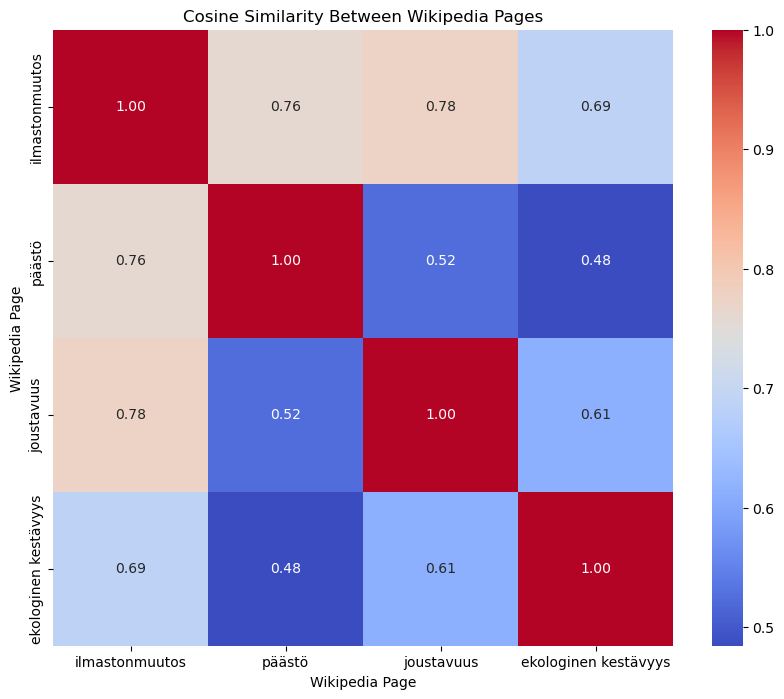

In [51]:
terms_list = list(terms)
# Calculate the cosine similarity between the pages and print the results in a matrix
page_similarity_matrix = np.zeros((len(terms_list), len(terms_list)))
for i, page_title_1 in enumerate(terms_list):
    for j, page_title_2 in enumerate(terms_list):
        similarity = cosine_similarity_between_pages(
            page_title_1, page_title_2, word2vec_fi_model, finnish_stopwords
        )
        page_similarity_matrix[i, j] = similarity

# Provide the result in a table
page_similarity_df = pd.DataFrame(
    page_similarity_matrix,
    index=terms_list,
    columns=terms_list,
)

print("\nCosine Similarity Between Wikipedia Pages:")
print(page_similarity_df)

# print results in a graph
plt.figure(figsize=(10, 8))
sns.heatmap(page_similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity Between Wikipedia Pages")
plt.xlabel("Wikipedia Page")
plt.ylabel("Wikipedia Page")
plt.show()

#### Comment on the compatibility between webpage content and concept and similarity between the various concepts.

Page 'päästö' has higher concept-to-content similarity, suggesting that the content is well-aligned with the main concepts. On the other hand, 'joustavuus' and 'ilmastonmuutos' have lower alignment, which could indicate more varied or less focused content. Additionally, the concept 'ekologinen kestävyys' was not found in the Word2Vec model vocabulary, so we were unable to retrieve any data for it.

Pages that are concept related, such as 'ilmastonmuutos' and 'päästö' show higher similarity, while less directly related topics like 'joustavuus' and 'päästö' show lower similarity. This suggests that related environmental concepts tend to cluster together based on their content.


### Task 10

Repeat 9) when the extended vocabulary is considered.


##### i)


In [52]:
# word2vec_fi = kagglehub.dataset_download("lehtol/word2vec-fi")
def evaluate_page_consistency(page_title, model, stop_words):
    # Get the page content
    page_content = words_extended_all[page_title]

    # Preprocess the page content
    clean_stopwords = [word.casefold() for word in stop_words]
    stemmer = SnowballStemmer("finnish")

    page_tokens = [stemmer.stem(word) for word in page_content]

    page_tokens = [
        word for word in page_tokens if word.isalpha() and word not in clean_stopwords
    ]

    page_tokens = list(set(page_tokens))

    # Get the embedding of the concept
    word = stemmer.stem(page_title)

    concept_embedding = get_word_embedding(word.casefold(), model)
    if concept_embedding is None:
        print(f"The concept '{page_title}' is not in the Word2Vec model vocabulary.")
        return

    # Get the average embedding of the page content
    avg_embedding = get_average_embedding(page_tokens, model)
    if avg_embedding is None:
        print(
            f"No words in the Wikipedia page '{page_title}' have embeddings in the Word2Vec model."
        )
        return

    # Calculate cosine similarity
    similarity = cosine_similarity_vectors(concept_embedding, avg_embedding)
    print(
        f"Cosine similarity between the page '{page_title}' and average embedding of the page content is: {similarity}"
    )

In [53]:
for title in terms:
    evaluate_page_consistency(title, word2vec_fi_model, finnish_stopwords)

Cosine similarity between the page 'ilmastonmuutos' and average embedding of the page content is: 0.282510906457901
Cosine similarity between the page 'päästö' and average embedding of the page content is: 0.3784734606742859
Cosine similarity between the page 'joustavuus' and average embedding of the page content is: 0.17818860709667206
The concept 'ekologinen kestävyys' is not in the Word2Vec model vocabulary.


##### ii)


In [54]:
# Function to get the aggregated embedding of a Wikipedia page
def get_page_embedding(page_title, model, stop_words):
    # Get the page content

    page_content = words_extended_all[page_title]

    # Check if the page exists
    if page_content is None:
        print(f"The Wikipedia page does not exist.")
        return None

    # Preprocess the page content
    clean_stopwords = [word.casefold() for word in stop_words]
    stemmer = SnowballStemmer("finnish")

    page_tokens = [stemmer.stem(word) for word in page_content]

    page_tokens = [
        word for word in page_tokens if word.isalpha() and word not in clean_stopwords
    ]

    page_tokens = list(set(page_tokens))

    # Get the average embedding of the page content
    avg_page_embedding = get_average_embedding(page_tokens, model)

    return avg_page_embedding


def cosine_similarity_between_pages(page_title_1, page_title_2, model, stop_words):
    # Get the aggregated embeddings for both pages
    # print(f"Calculating cosine similarity between '{page_title_1}' and '{page_title_2}'")
    embedding_1 = get_page_embedding(page_title_1, model, stop_words)
    embedding_2 = get_page_embedding(page_title_2, model, stop_words)

    # print(f"Embedding 1: {embedding_1}, Embedding 2: {embedding_2}")

    # Check if embeddings exist for both pages
    if embedding_1 is None or embedding_2 is None:
        print("One or both pages do not have valid embeddings.")
        return None

    # Reshape the embeddings for cosine similarity calculation
    embedding_1 = embedding_1.reshape(1, -1)
    embedding_2 = embedding_2.reshape(1, -1)

    # Calculate and return the cosine similarity
    similarity = cosine_similarity(embedding_1, embedding_2)[0][0]
    return similarity


Cosine Similarity Between Wikipedia Pages:
                      ilmastonmuutos    päästö  joustavuus  \
ilmastonmuutos              1.000000  0.956845    0.954803   
päästö                      0.956845  1.000000    0.903783   
joustavuus                  0.954803  0.903783    1.000000   
ekologinen kestävyys        0.949293  0.953858    0.922904   

                      ekologinen kestävyys  
ilmastonmuutos                    0.949293  
päästö                            0.953858  
joustavuus                        0.922904  
ekologinen kestävyys              1.000000  


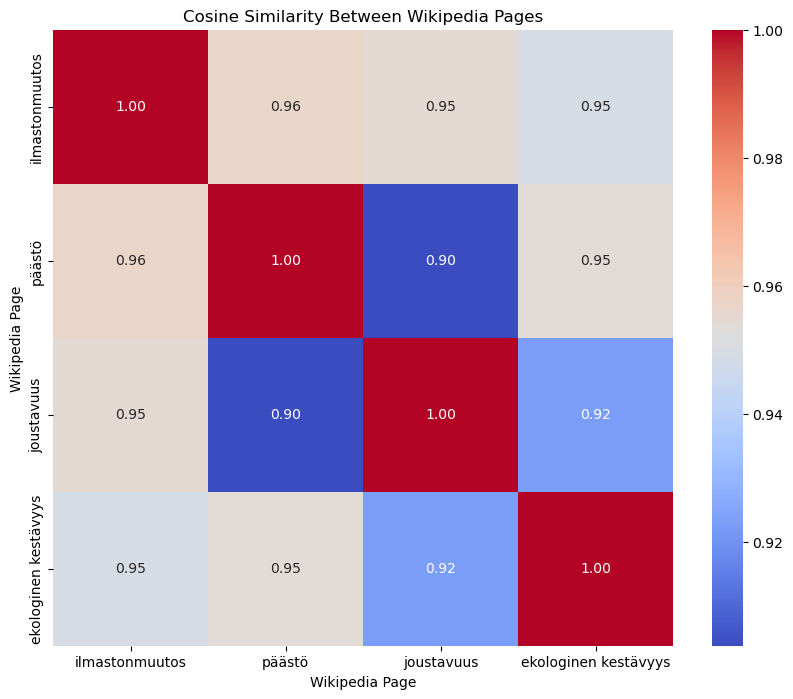

In [55]:
terms_list = list(terms)
# Calculate the cosine similarity between the pages and print the results in a matrix
page_similarity_matrix = np.zeros((len(terms_list), len(terms_list)))
for i, page_title_1 in enumerate(terms_list):
    for j, page_title_2 in enumerate(terms_list):
        similarity = cosine_similarity_between_pages(
            page_title_1, page_title_2, word2vec_fi_model, finnish_stopwords
        )
        page_similarity_matrix[i, j] = similarity

# Provide the result in a table
page_similarity_df = pd.DataFrame(
    page_similarity_matrix,
    index=terms_list,
    columns=terms_list,
)

print("\nCosine Similarity Between Wikipedia Pages:")
print(page_similarity_df)

# print results in a graph
plt.figure(figsize=(10, 8))
sns.heatmap(page_similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity Between Wikipedia Pages")
plt.xlabel("Wikipedia Page")
plt.ylabel("Wikipedia Page")
plt.show()

#### Comment on the compatibility between webpage content and concept and similarity between the various concepts.

When extended vocabulary is used all the pages have lower alignment, which could indicate more varied or less focused content and a larger range of sutopics, that may affect the aligment of the main consepts. Additionally, the concept 'ekologinen kestävyys' was not found in the Word2Vec model vocabulary, so we were unable to retrieve any data for it.

High cosine similarities reflect the interrelated nature of these environmental themes, as they often share terminology, concepts and possibly referenced entities in Wikipedia.


### Task 11

Use appropriate literature to comment on the findings. Also, identify any additional input that would allow you to further elucidate any of the preceding, and use appropriate literature of corpus linguistic literature to justify your findings and comment on the obtained results. Finally, comment on the limitations and structural weakness of the data processing pipeline.
